<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#SIMULATE-DATA" data-toc-modified-id="SIMULATE-DATA-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>SIMULATE DATA</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#SIMPLE-ATE-ESTIMATORS" data-toc-modified-id="SIMPLE-ATE-ESTIMATORS-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>SIMPLE ATE ESTIMATORS</a></span><ul class="toc-item"><li><span><a href="#Frisch-Waugh-Lowell-theorem" data-toc-modified-id="Frisch-Waugh-Lowell-theorem-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Frisch-Waugh-Lowell theorem</a></span></li></ul></li></ul></div>

In [1]:

import pandas as pd
import numpy as np
import scipy.stats as stats
import random as r
import warnings
warnings.filterwarnings('ignore')
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from joblib import Parallel, delayed
from pylab import *
from IPython.display import Image
import matplotlib.ticker as mtick
style.use("fivethirtyeight")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from src.dgp import dgp_compare

### SIMULATE DATA

In [56]:
df = dgp_compare().generate_data(include_beta=True)
df.head()

,outcome,treated,male,age,income,beta
0,38.68,False,0,28.0,1514.0,2.726425
1,37.81,False,1,47.0,1524.0,2.777192
2,27.70,False,0,60.0,2683.0,0.247312
3,29.56,False,0,29.0,3021.0,2.632797
4,36.83,False,0,25.0,1859.0,1.724331


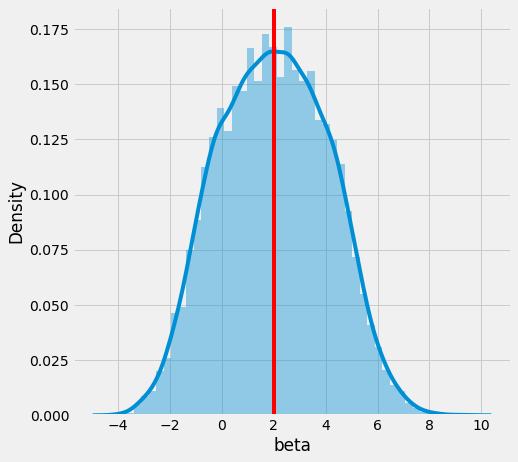

In [57]:
rcParams['figure.figsize'] = 7,7
sns.distplot(df['beta'])
plt.axvline(np.mean(df['beta']), color ='red')

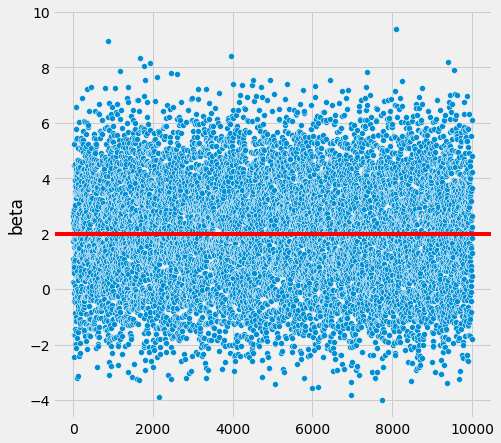

In [58]:
sns.scatterplot(df['beta'])
plt.axhline(np.mean(df['beta']), color ='red')

### EDA

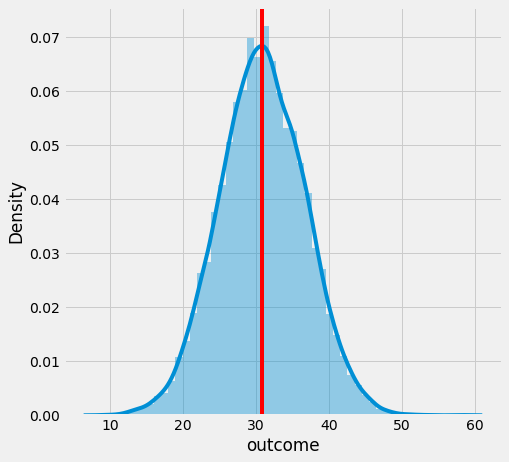

In [59]:
rcParams['figure.figsize'] = 7,7
sns.distplot(df['outcome'])
plt.axvline(np.mean(df['outcome']), color ='red')

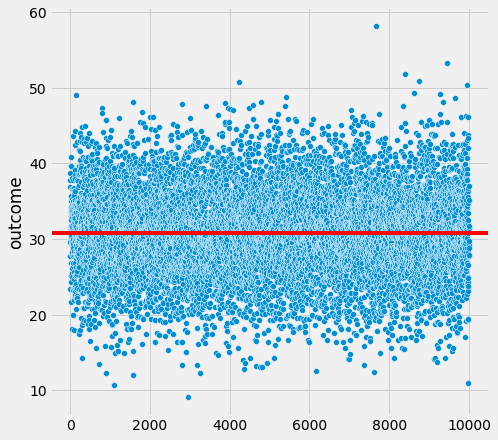

In [60]:
sns.scatterplot(df['outcome'])
plt.axhline(np.mean(df['outcome']), color ='red')

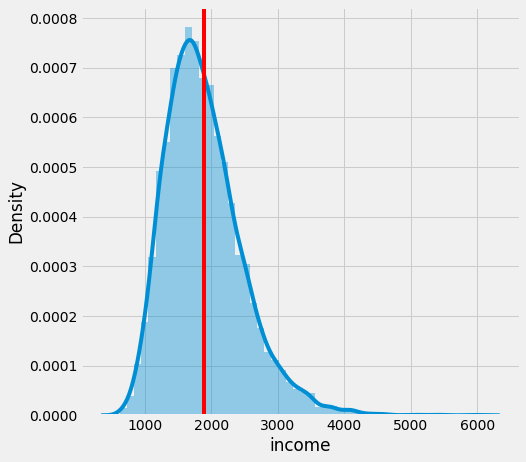

In [61]:
rcParams['figure.figsize'] = 7,7
sns.distplot(df['income'])
plt.axvline(np.mean(df['income']), color ='red')

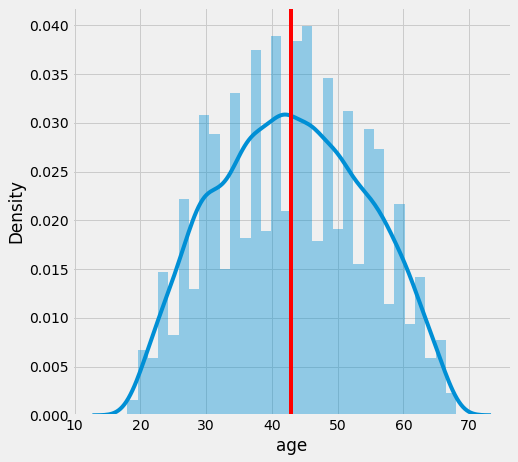

In [62]:
rcParams['figure.figsize'] = 7,7
sns.distplot(df['age'])
plt.axvline(np.mean(df['age']), color ='red')

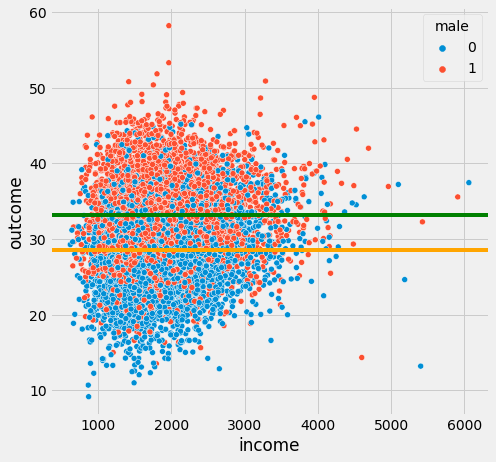

In [63]:
sns.scatterplot(data = df, y ='outcome', x = 'income', hue="male")
plt.axhline(np.mean(df.loc[df['male']==1].outcome), color ='green')
plt.axhline(np.mean(df.loc[df['male']==0].outcome), color ='orange')

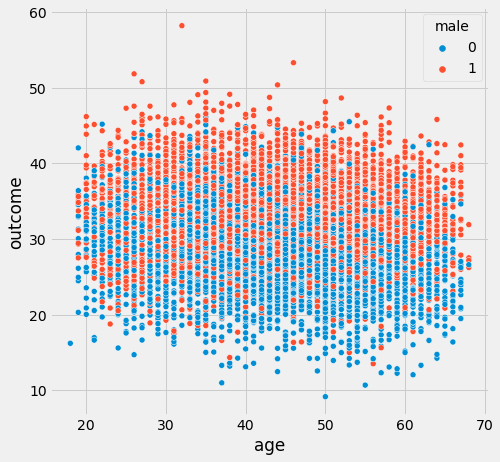

In [64]:
sns.scatterplot(data = df, y ='outcome', x = 'age', hue="male")

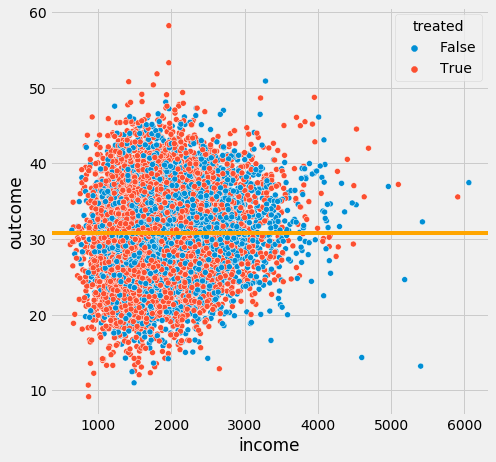

In [65]:
sns.scatterplot(data = df, y ='outcome', x = 'income', hue="treated")
plt.axhline(np.mean(df.loc[df['treated']==True].outcome), color ='green')
plt.axhline(np.mean(df.loc[df['treated']==False].outcome), color ='orange')

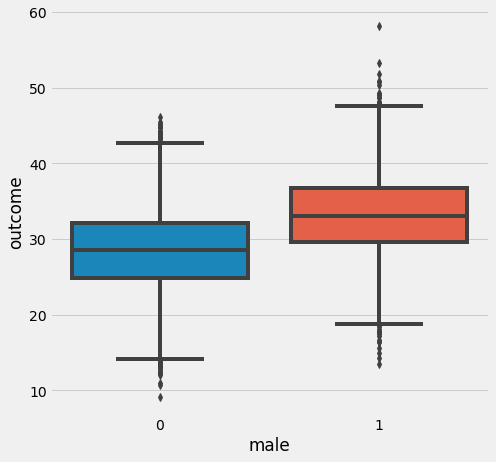

In [66]:
sns.boxplot(data=df, x="male", y="outcome")

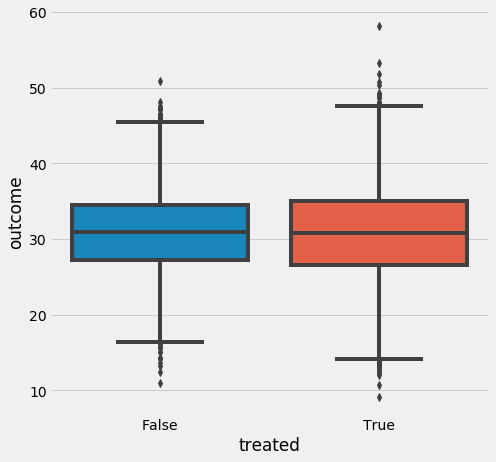

In [67]:
sns.boxplot(data=df, x="treated", y="outcome")

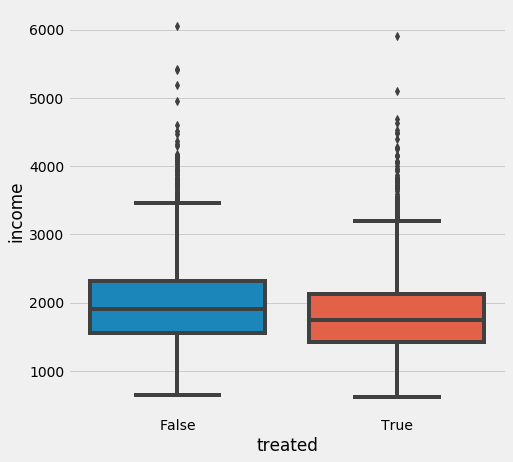

In [68]:
sns.boxplot(data=df, x="treated", y="income")

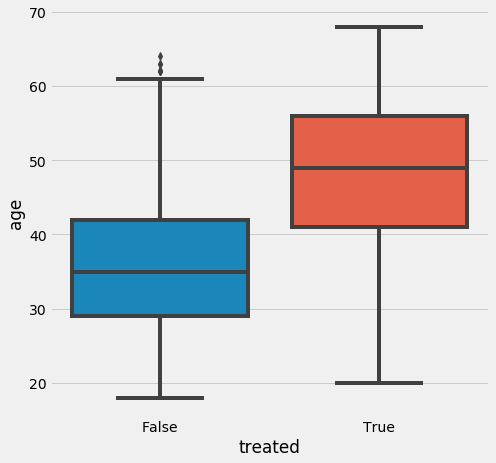

In [69]:
sns.boxplot(data=df, x="treated", y="age")

### SIMPLE ATE ESTIMATORS

In [70]:
def difference_in_means(df, treatment, target):
        mean_treatment = np.mean(df[df[treatment]==True][target])
        mean_control = np.mean(df[df[treatment]==False][target])
        return mean_treatment - mean_control

In [71]:
difference_in_means(df, 'treated', 'outcome')

-0.006043869567882609

1. Exact Fisher's Permutation Test

In [72]:
def permute(data, var, r):
    temp_data = data.copy()
    temp_data[var] = np.random.choice(data[var], size=len(data), replace=r)
    return temp_data

def permutation_test(data, permute, var, compute_stat, K=1000, r=False):
    T = compute_stat(data)
    T_perm = []
    for k in range(K):
        temp_data = permute(data, var, r)
        T_perm += [compute_stat(temp_data)]
    print(f"The p-value is {sum(np.abs(T_perm) >= np.abs(T))/K}")
    return T_perm

In [73]:
def compute_statistic_diff(data):
    T = np.mean(data.loc[data['treated']==True, 'outcome']) - np.mean(data.loc[data['treated']==False, 'outcome'])
    return T

In [74]:
Ts = permutation_test(df, permute, 'outcome', compute_statistic_diff)

The p-value is 0.956


In [75]:
Ts[-1], np.mean(Ts), Ts[0]

(-0.05283366818008872, 0.000970779723376161, 0.10577686644445805)

2. Bootstrapped Difference in Means

In [76]:
def bootstrap(df, treatment, target, label, BS_SAMPLE, plot_kde=True, seed=123):
    np.random.seed(seed)
    ates = Parallel(n_jobs=4)(delayed(difference_in_means)(df.sample(frac=1, replace=True), treatment, target) for _ in range(BS_SAMPLE))

    ates = np.array(ates)

    print(f"Bootstraped QOI: {ates.mean()}")
    print(f"95% C.I: {(np.percentile(ates, 2.5), np.percentile(ates, 97.5))}")

    if plot_kde:
        plt.hist(ates, alpha=.5, label=label)
        sns.despine()
        plt.legend(loc='center left', bbox_to_anchor=(1, .5))
        plt.axvline(ates.mean(), color ='red')
        plt.axvline(np.percentile(ates, 2.5), color ='orange')
        plt.axvline(np.percentile(ates, 97.5), color ='orange')

    return ates

Bootstraped QOI: -0.007800103662520868
95% C.I: (-0.23030208328621554, 0.22052698156239572)


array([ 1.78161849e-01, -2.56654404e-01,  4.92486307e-02,  1.44809735e-02,
       -9.11094461e-02, -3.33148117e-03, -4.35038918e-02, -5.39515166e-02,
       -2.21186513e-02, -1.54506606e-01,  9.77333076e-02, -1.00810446e-01,
        1.77643817e-01,  5.92776250e-02, -9.17166316e-03, -5.28451958e-02,
       -2.17922550e-01, -2.23508423e-01,  5.80305508e-02, -1.09990073e-02,
       -9.04030338e-02,  2.15671926e-01,  1.86190659e-01, -1.98848633e-02,
       -4.69740376e-02, -1.04421563e-01, -3.31328624e-04,  8.21970616e-02,
       -2.45323319e-02,  1.22646315e-01, -1.12345306e-02,  8.11663800e-02,
       -5.39537481e-02, -2.74189332e-02,  8.12809157e-02,  1.04893865e-01,
       -2.68497125e-02, -5.01965889e-02,  5.09370467e-02,  6.85309722e-03,
        7.40831347e-02, -1.31282846e-01,  1.16065104e-01,  3.60437100e-02,
       -5.39773321e-02, -1.61607093e-01,  1.11777160e-01, -9.44589414e-02,
        1.56004324e-01,  4.91801775e-02, -1.05831951e-01,  4.10992038e-02,
        4.17158045e-02,  

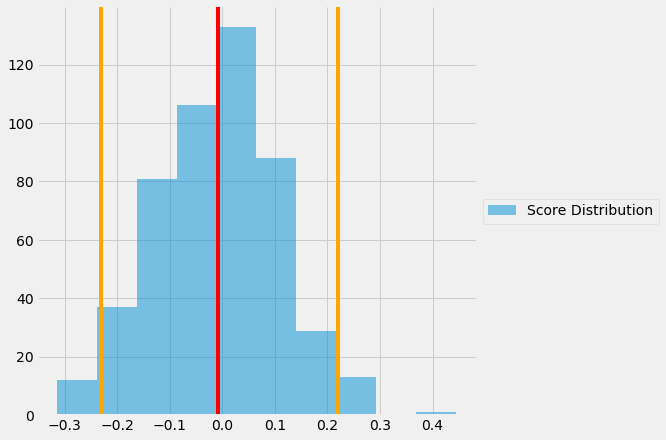

In [77]:
bootstrap(df, 'treated', 'outcome', 'Score Distribution', 500, plot_kde=True, seed=123)

3. Parametric Difference in Means

In [78]:
from scipy.stats import ttest_ind

ttest_ind(df.query('treated==True')['outcome'], df.query('treated==0')['outcome'])

Ttest_indResult(statistic=-0.051104766640237664, pvalue=0.9592430586410857)

4. Simple Diference in Means: E(Y|D) = Bo + B1*D

In [79]:
smf.ols('outcome ~ treated', data=df).fit(cov_type='HC3').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                outcome   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                  0.002728
Date:                Thu, 30 Mar 2023   Prob (F-statistic):              0.958
Time:                        09:52:51   Log-Likelihood:                -31811.
No. Observations:               10000   AIC:                         6.363e+04
Df Residuals:                    9998   BIC:                         6.364e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          30.8496      0.084    368.733      0.000      30.686      31.014
treated[T.True]    -0.0060      0.116     -0.052      0.958      -0.233       0.221
==============================================================================
Omnibus:                        0.118   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.943   Jarque-Bera (JB):                0.132
Skew:                           0.007   Prob(JB):                        0.936
Kurtosis:                       2.989   Cond. No.                         2.87
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

5. Simple Diference in Means: E(Y|D, X) = Bo + B1*D + B' X

In [81]:
model1 = smf.ols('outcome ~ treated + income + male + age', data=df).fit(cov_type='HC3')
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                outcome   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     659.0
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        09:53:49   Log-Likelihood:                -30605.
No. Observations:               10000   AIC:                         6.122e+04
Df Residuals:                    9995   BIC:                         6.126e+04
Df Model:                           4                                         
Covariance Type:                  HC3                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          29.5761      0.275    107.667      0.000      29.038      30.115
treated[T.True]     2.2682      0.129     17.642      0.000       2.016       2.520
income              0.0014    9.3e-05     15.515      0.000       0.001       0.002
male                4.8568      0.104     46.501      0.000       4.652       5.061
age                -0.1215      0.006    -21.775      0.000      -0.132      -0.111
==============================================================================
Omnibus:                        2.400   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.301   Jarque-Bera (JB):                2.456
Skew:                          -0.005   Prob(JB):                        0.293
Kurtosis:                       3.076   Cond. No.                     1.04e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 1.04e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [83]:
model2 = smf.ols('outcome ~ treated + C(male) + C(age) + income', data=df).fit(cov_type='HC3')
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                outcome   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     52.09
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        09:54:50   Log-Likelihood:                -30570.
No. Observations:               10000   AIC:                         6.125e+04
Df Residuals:                    9946   BIC:                         6.164e+04
Df Model:                          53                                         
Covariance Type:                  HC3                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          13.7441      1.835      7.488      0.000      10.147      17.342
treated[T.True]     2.2734      0.129     17.597      0.000       2.020       2.527
C(male)[T.1]        4.8572      0.105     46.258      0.000       4.651       5.063
C(age)[T.19.0]     12.3224      2.128      5.790      0.000       8.151      16.493
C(age)[T.20.0]     13.3590      1.960      6.814      0.000       9.517      17.201
C(age)[T.21.0]     12.0239      1.963      6.124      0.000       8.176      15.872
C(age)[T.22.0]     12.1582      1.905      6.384      0.000       8.425      15.891
C(age)[T.23.0]     12.6572      1.891      6.692      0.000       8.950      16.364
C(age)[T.24.0]     12.2288      1.898      6.444      0.000       8.509      15.948
C(age)[T.25.0]     12.8140      1.889      6.782      0.000       9.111      16.517
C(age)[T.26.0]     12.0756      1.882      6.417      0.000       8.387      15.764
C(age)[T.27.0]     12.6104      1.878      6.715      0.000       8.930      16.291
C(age)[T.28.0]     12.6585      1.865      6.788      0.000       9.003      16.314
C(age)[T.29.0]     12.0590      1.860      6.485      0.000       8.414      15.704
C(age)[T.30.0]     11.9888      1.860      6.445      0.000       8.343      15.635
C(age)[T.31.0]     12.0802      1.864      6.482      0.000       8.428      15.733
C(age)[T.32.0]     12.3509      1.861      6.638      0.000       8.704      15.998
C(age)[T.33.0]     12.8118      1.864      6.875      0.000       9.159      16.464
C(age)[T.34.0]     11.1164      1.861      5.972      0.000       7.468      14.765
C(age)[T.35.0]     12.0758      1.861      6.489      0.000       8.428      15.723
C(age)[T.36.0]     12.1778      1.854      6.568      0.000       8.544      15.812
C(age)[T.37.0]     10.8421      1.857      5.837      0.000       7.202      14.483
C(age)[T.38.0]     11.4749      1.857      6.180      0.000       7.836      15.114
C(age)[T.39.0]     11.4117      1.855      6.151      0.000       7.776      15.048
C(age)[T.40.0]     10.5136      1.856      5.664      0.000       6.876      14.152
C(age)[T.41.0]     11.3540      1.856      6.117      0.000       7.716      14.992
C(age)[T.42.0]     10.6879      1.851      5.774      0.000       7.060      14.316
C(age)[T.43.0]     10.5576      1.854      5.696      0.000       6.925      14.190
C(age)[T.44.0]     10.8134      1.858      5.819      0.000       7.171      14.455
C(age)[T.45.0]     10.3116      1.854      5.562      0.000       6.678      13.945
C(age)[T.46.0]     10.3937      1.854      5.606      0.000       6.760      14.028
C(age)[T.47.0]     10.4563      1.857      5.630      0.000       6.816      14.097
C(age)[T.48.0]      9.9260      1.855      5.350      0.000       6.290      13.563
C(age)[T.49.0]      9.4878      1.860      5.101      0.000

In [84]:
df['binned_age'] = pd.cut(x=df['age'], bins=[20, 40, 60, 99],labels=['young', 'middle', 'old'])

In [85]:
model3 = smf.ols('outcome ~ treated + C(male) + C(binned_age) + income', data=df).fit(cov_type='HC3')
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                outcome   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     489.5
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        09:55:55   Log-Likelihood:                -30451.
No. Observations:                9927   AIC:                         6.091e+04
Df Residuals:                    9921   BIC:                         6.096e+04
Df Model:                           5                                         
Covariance Type:                  HC3                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  25.9147      0.213    121.444      0.000      25.496      26.333
treated[T.True]             1.8112      0.124     14.635      0.000       1.569       2.054
C(male)[T.1]                4.8123      0.105     45.633      0.000       4.606       5.019
C(binned_age)[T.middle]    -1.9111      0.122    -15.657      0.000      -2.150      -1.672
C(binned_age)[T.old]       -3.3709      0.236    -14.265      0.000      -3.834      -2.908
income                      0.0014   9.41e-05     14.842      0.000       0.001       0.002
==============================================================================
Omnibus:                        3.249   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.197   Jarque-Bera (JB):                3.396
Skew:                          -0.002   Prob(JB):                        0.183
Kurtosis:                       3.091   Cond. No.                     9.49e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 9.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [86]:
model4 = smf.ols('outcome ~ treated + C(male)*income + C(binned_age)*income', data=df).fit(cov_type='HC3')
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                outcome   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     312.5
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        09:57:42   Log-Likelihood:                -30437.
No. Observations:                9927   AIC:                         6.089e+04
Df Residuals:                    9918   BIC:                         6.096e+04
Df Model:                           8                                         
Covariance Type:                  HC3                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         25.7188      0.368     69.797      0.000      24.997      26.441
treated[T.True]                    1.8111      0.124     14.618      0.000       1.568       2.054
C(male)[T.1]                       6.3502      0.366     17.357      0.000       5.633       7.067
C(binned_age)[T.middle]           -2.9327      0.388     -7.556      0.000      -3.693      -2.172
C(binned_age)[T.old]              -4.0499      0.800     -5.064      0.000      -5.617      -2.482
income                             0.0015      0.000      8.144      0.000       0.001       0.002
C(male)[T.1]:income               -0.0008      0.000     -4.416      0.000      -0.001      -0.000
C(binned_age)[T.middle]:income     0.0005      0.000      2.798      0.005       0.000       0.001
C(binned_age)[T.old]:income        0.0004      0.000      0.892      0.373      -0.000       0.001
==============================================================================
Omnibus:                        2.617   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.270   Jarque-Bera (JB):                2.696
Skew:                           0.003   Prob(JB):                        0.260
Kurtosis:                       3.080   Cond. No.                     3.87e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 3.87e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [87]:
model5 = smf.ols('outcome ~ treated + C(binned_age)*income', data=df).fit(cov_type='HC3')
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                outcome   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     60.15
Date:                Thu, 30 Mar 2023   Prob (F-statistic):           1.63e-73
Time:                        09:58:18   Log-Likelihood:                -31397.
No. Observations:                9927   AIC:                         6.281e+04
Df Residuals:                    9920   BIC:                         6.286e+04
Df Model:                           6                                         
Covariance Type:                  HC3                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         29.3546      0.321     91.472      0.000      28.726      29.984
treated[T.True]                    1.1723      0.133      8.792      0.000       0.911       1.434
C(binned_age)[T.middle]           -3.0166      0.421     -7.159      0.000      -3.842      -2.191
C(binned_age)[T.old]              -3.2435      0.879     -3.690      0.000      -4.966      -1.521
income                             0.0010      0.000      6.098      0.000       0.001       0.001
C(binned_age)[T.middle]:income     0.0007      0.000      3.283      0.001       0.000       0.001
C(binned_age)[T.old]:income        0.0002      0.000      0.515      0.606      -0.001       0.001
==============================================================================
Omnibus:                        0.124   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.940   Jarque-Bera (JB):                0.143
Skew:                           0.006   Prob(JB):                        0.931
Kurtosis:                       2.985   Cond. No.                     3.51e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 3.51e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

EXTRA: Freeman's Critique (Lin *Agnostic notes on regression adjustments to experimental data: reexamining freedman's critique*)

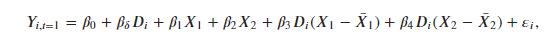

In [88]:
male_dummies = pd.get_dummies(df['male'], drop_first=True)

In [89]:
male_dummies = pd.get_dummies(df['male'], drop_first=True)
centered_income = df['income'] - df['income'].mean()
centered_male_dummies = male_dummies - male_dummies.mean()
centered_age = df['age'] - df['age'].mean()

In [90]:
centered_data = pd.concat([df[['outcome', 'treated', 'income', 'male', 'age']], centered_income, centered_male_dummies, centered_age], axis = 1)
centered_data.columns = ['outcome', 'treated', 'income', 'male', 'age', 'centered_income', 'centered_male', 'centered_age']

In [91]:
centered_data

,outcome,treated,income,male,age,centered_income,centered_male,centered_age
0,38.68,False,1514.0,0,28.0,-375.5493,-0.501,-14.9374
1,37.81,False,1524.0,1,47.0,-365.5493,0.499,4.0626
2,27.70,False,2683.0,0,60.0,793.4507,-0.501,17.0626
3,29.56,False,3021.0,0,29.0,1131.4507,-0.501,-13.9374
4,36.83,False,1859.0,0,25.0,-30.5493,-0.501,-17.9374
...,...,...,...,...,...,...,...,...
9995,31.72,False,2135.0,1,37.0,245.4507,0.499,-5.9374
9996,37.08,False,2011.0,0,38.0,121.4507,-0.501,-4.9374
9997,27.76,True,2270.0,0,65.0,380.4507,-0.501,22.0626
9998,27.84,False,2152.0,0,29.0,262.4507,-0.501,-13.9374


In [92]:
model_specification = ('treated + income + male + age + ' + '(treated:centered_income) + (treated:centered_age) + (treated:centered_male)' )
model6 = smf.ols(f'outcome ~ {model_specification}', data=centered_data).fit(cov_type='HC3')
model6.summary()

c:\Users\sorel\Anaconda3\Anaconda3PAW\lib\site-packages\statsmodels\base\model.py:1873: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 10, but rank is 8
  'rank is %d' % (J, J_), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                outcome   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                 4.610e+04
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        09:59:20   Log-Likelihood:                -30481.
No. Observations:               10000   AIC:                         6.098e+04
Df Residuals:                    9992   BIC:                         6.104e+04
Df Model:                           7                                         
Covariance Type:                  HC3                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                       2.516e-05   1.58e-07    158.891      0.000    2.48e-05    2.55e-05
treated[T.True]                    1.9790      0.129     15.314      0.000       1.726       2.232
income                             0.0168   7.86e-05    213.260      0.000       0.017       0.017
male                               3.0583      0.070     43.772      0.000       2.921       3.195
age                               -0.0739      0.004    -19.667      0.000      -0.081      -0.067
treated[False]:centered_income    -0.0158      0.000    -95.269      0.000      -0.016      -0.015
treated[True]:centered_income     -0.0150      0.000   -108.124      0.000      -0.015      -0.015
treated[False]:centered_age        0.0019      0.006      0.306      0.760      -0.010       0.014
treated[True]:centered_age        -0.0769      0.006    -13.916      0.000      -0.088      -0.066
treated[False]:centered_male       0.0437      0.116      0.375      0.707      -0.184       0.272
treated[True]:centered_male        3.0146      0.104     28.927      0.000       2.810       3.219
==============================================================================
Omnibus:                        4.529   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.104   Jarque-Bera (JB):                4.822
Skew:                          -0.009   Prob(JB):                       0.0897
Kurtosis:                       3.106   Cond. No.                     7.64e+18
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The smallest eigenvalue is 6.73e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

####  Frisch-Waugh-Lowell theorem

In [93]:
from src.dgp import dgp_store_coupons

df = dgp_store_coupons().generate_data(N=50)
df.head()

,sales,coupons,income,dayofweek
0,821.7,0.199,66.243,2
1,602.3,0.245,43.882,3
2,655.1,0.162,44.718,5
3,625.8,0.269,39.270,4
4,696.6,0.186,58.654,1


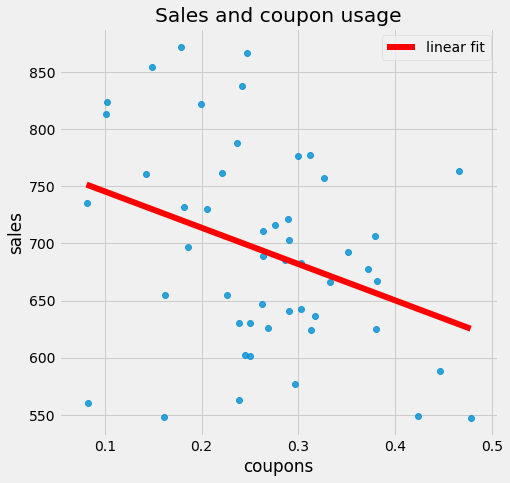

In [96]:
sns.regplot(x="coupons", y="sales", data=df, ci=False, line_kws={'color':'r', 'label':'linear fit'})
plt.legend()
plt.title(f"Sales and coupon usage");

ATE estimation

In [99]:
smf.ols('sales ~ coupons + income', df).fit(cov='HC3').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     224.8
Date:                Thu, 30 Mar 2023   Prob (F-statistic):           8.67e-25
Time:                        10:02:04   Log-Likelihood:                -235.43
No. Observations:                  50   AIC:                             476.9
Df Residuals:                      47   BIC:                             482.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    161.4982     33.253      4.857      0.000      94.601     228.395
coupons      218.7548     50.058      4.370      0.000     118.052     319.458
income         9.5094      0.480     19.818      0.000       8.544      10.475
==============================================================================
Omnibus:                        1.207   Durbin-Watson:                   2.373
Prob(Omnibus):                  0.547   Jarque-Bera (JB):                1.234
Skew:                          -0.329   Prob(JB):                        0.540
Kurtosis:                       2.599   Cond. No.                         743.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [100]:
df['coupons_tilde'] = smf.ols('coupons ~ income', df).fit().resid

smf.ols('sales ~ coupons_tilde - 1', df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
coupons_tilde,218.7548,1275.236,0.172,0.865,-2343.929,2781.438


In [101]:
df['sales_tilde'] = smf.ols('sales ~ income', df).fit().resid

smf.ols('sales_tilde ~ coupons_tilde - 1', df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
coupons_tilde,218.7548,49.025,4.462,0.000,120.235,317.275


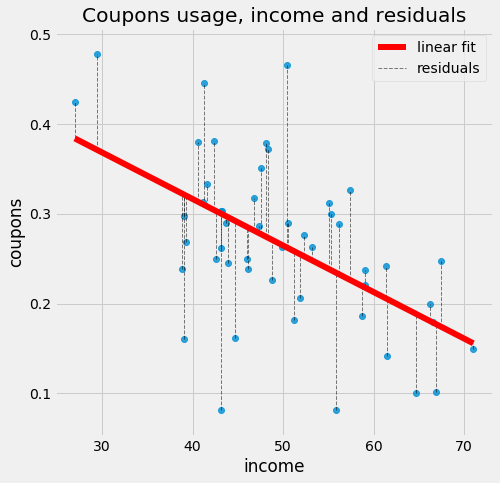

In [102]:
df["coupons_hat"] = smf.ols('coupons ~ income', df).fit().predict()
ax = sns.regplot(x="income", y="coupons", data=df, ci=False, line_kws={'color':'r', 'label':'linear fit'})
ax.vlines(df["income"], np.minimum(df["coupons"], df["coupons_hat"]), np.maximum(df["coupons"], df["coupons_hat"]), 
           linestyle='--', color='k', alpha=0.5, linewidth=1, label="residuals");
plt.legend()
plt.title(f"Coupons usage, income and residuals");

In [103]:
smf.ols('sales ~ coupons + income + dayofweek', df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,124.2721,28.764,4.320,0.000,66.182,182.362
dayofweek[T.2],7.7703,14.607,0.532,0.598,-21.729,37.270
dayofweek[T.3],15.0895,11.678,1.292,0.204,-8.495,38.674
dayofweek[T.4],28.2762,9.868,2.866,0.007,8.348,48.204
dayofweek[T.5],44.0937,10.214,4.317,0.000,23.467,64.720
dayofweek[T.6],50.7664,13.130,3.866,0.000,24.249,77.283
dayofweek[T.7],57.3142,12.413,4.617,0.000,32.245,82.383
coupons,192.0262,39.140,4.906,0.000,112.981,271.071
income,9.8152,0.404,24.314,0.000,9.000,10.630


In [104]:
df['coupons_tilde'] = smf.ols('coupons ~ income + dayofweek', df).fit().resid
df['sales_tilde'] = smf.ols('sales ~ income + dayofweek', df).fit().resid
smf.ols('sales_tilde ~ coupons_tilde - 1', df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
coupons_tilde,192.0262,35.803,5.363,0.000,120.078,263.974


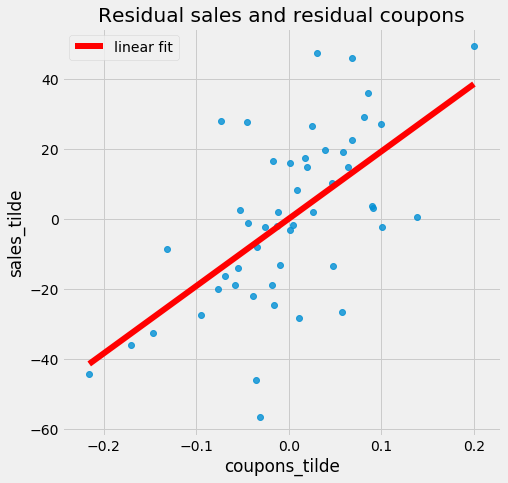

In [105]:
sns.regplot(x="coupons_tilde", y="sales_tilde", data=df, ci=False, line_kws={'color':'r', 'label':'linear fit'})
plt.legend()
plt.title(f"Residual sales and residual coupons");

In [106]:
df['coupons_tilde_scaled'] = df['coupons_tilde'] + np.mean(df['coupons'])
df['sales_tilde_scaled'] = df['sales_tilde'] + np.mean(df['sales'])

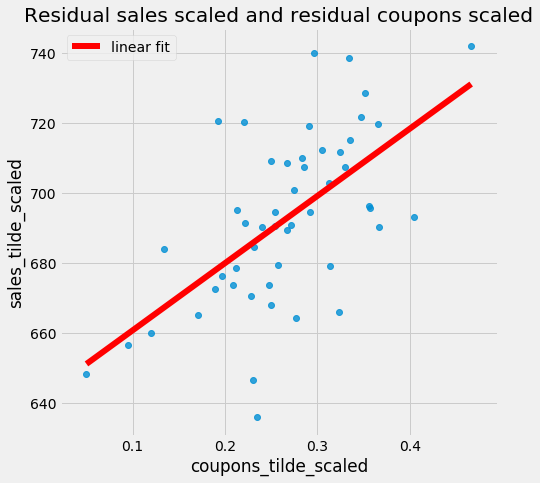

In [107]:
sns.regplot(x="coupons_tilde_scaled", y="sales_tilde_scaled", data=df, ci=False, line_kws={'color':'r', 'label':'linear fit'})
plt.legend()
plt.title(f"Residual sales scaled and residual coupons scaled");

In [108]:
smf.ols('sales_tilde_scaled ~ coupons_tilde_scaled', df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,641.6486,10.017,64.054,0.000,621.507,661.790
coupons_tilde_scaled,192.0262,36.174,5.308,0.000,119.294,264.758
